In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score, precision_recall_curve,brier_score_loss, plot_confusion_matrix,plot_roc_curve,log_loss,plot_precision_recall_curve
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings("ignore")

import pickle

# with open(r"Train_test_samples/train_test_split1_new.pkl","rb") as a:
#     train_test_split = pickle.load(a)
# with open(r"saved_pickle/encoders_new.pkl","rb") as a:
#     encoders = pickle.load(a)

# X_train = train_test_split['X_train']
# X_test = train_test_split['X_test']
# X_val = train_test_split['X_val']

# y_train = train_test_split['y_train']
# y_test = train_test_split['y_test']
# y_val = train_test_split['y_val']


# min_scaler = encoders['min_scaler']
# std_scaler = encoders['std_scaler']
# encoder = encoders['encoder']

In [2]:
import pickle
# with open("best_rf_model.sav","rb") as rf:
#     lr = pickle.load(rf)

with open(r"Train_test_samples/train_test_split1.pkl","rb") as a:
    train_test_split = pickle.load(a)
with open(r"saved_pickle/encoders.pkl","rb") as a:
    encoders = pickle.load(a)

In [3]:
X_train = train_test_split['X_train']
X_test = train_test_split['X_test']
y_train = train_test_split['y_train']
y_test = train_test_split['y_test']


min_scaler = encoders['min_scaler']
std_scaler = encoders['std_scaler']
encoder = encoders['encoder']

In [4]:
numerical_cols = min_scaler.transform(X_train.select_dtypes(exclude='object'))
categorical_cols = encoder.transform(X_train.select_dtypes(include='object'))

X_train_scaled = np.hstack((numerical_cols,categorical_cols))

In [5]:
numerical_cols_ = min_scaler.transform(X_val.select_dtypes(exclude='object'))
categorical_cols_ = encoder.transform(X_val.select_dtypes(include='object'))

X_val_scaled = np.hstack((numerical_cols_,categorical_cols_))

NameError: name 'X_val' is not defined

In [6]:
numerical_cols__ = min_scaler.transform(X_test.select_dtypes(exclude='object'))
categorical_cols__ = encoder.transform(X_test.select_dtypes(include='object'))

X_test_scaled = np.hstack((numerical_cols__,categorical_cols__))

In [7]:
def accuracy_func(x,y,over,model):
        x_ = x[x["current_over"]>=over]
        y_ = y[x["current_over"]>=over]
        
        numerical_cols = std_scaler.transform(x_.select_dtypes(exclude='object'))
        categorical_cols = encoder.transform(x_.select_dtypes(include='object'))

        x_ = np.hstack((numerical_cols,categorical_cols))
        return model.score(x_,y_)
        
     

In [8]:
def plot_scores(model,name):
    accuracy_list_train = []
    accuracy_list_test = []
    for i in range(20):

        accuracy_list_train.append(accuracy_func(X_train,y_train,i,model))
        accuracy_list_test.append(accuracy_func(X_test,y_test,i,model))

    import matplotlib.pyplot as plt
    plt.plot(range(1,21),accuracy_list_train)
    plt.plot(range(1,21),accuracy_list_test)
    plt.title(name)
    plt.xlabel('Over')
    plt.ylabel('Accuracy_score')
    plt.xticks(range(1,21))
    plt.grid()
    return plt.show()    

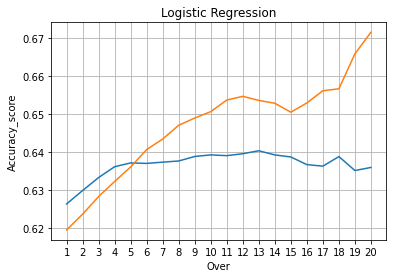

Training Accuracy: 0.6786748708639767
Test Accuracy: 0.6240320962888666
F1Score: 0.6688809582700259


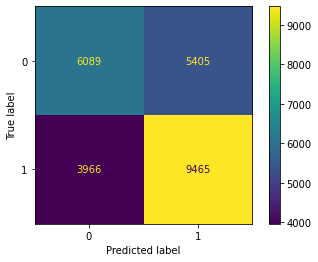

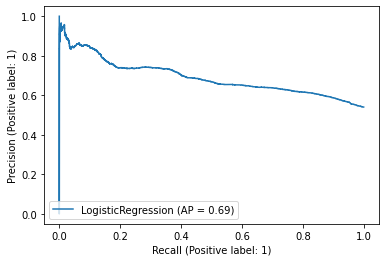

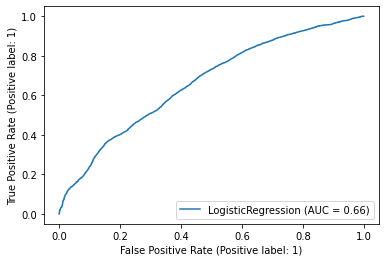

In [9]:
lr = LogisticRegression(penalty='l2',C = 0.04, solver='liblinear', class_weight={0:0.6,1:0.5})
lr.fit(X_train_scaled,y_train)
plot_scores(lr,'Logistic Regression')
print('Training Accuracy:',accuracy_score(y_train,lr.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_test,lr.predict(X_test_scaled)))
plot_confusion_matrix(lr,X_test_scaled,y_test)
plot_precision_recall_curve(lr,X_test_scaled,y_test)
plot_roc_curve(lr, X_test_scaled,y_test)
print('F1Score:', f1_score(y_test,lr.predict(X_test_scaled)))

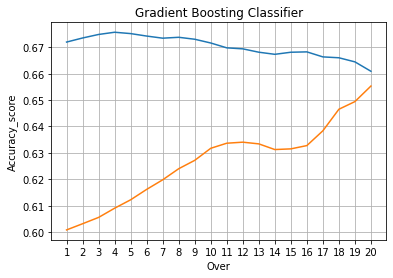

Training Accuracy: 0.7151365901151137
Test Accuracy: 0.5987629688747007
F1Score: 0.6709498753807809


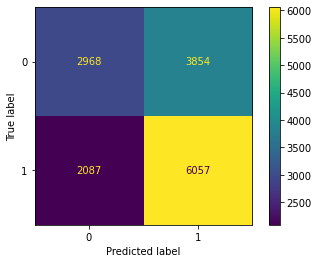

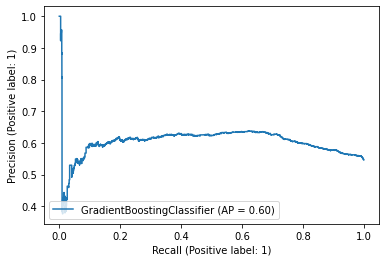

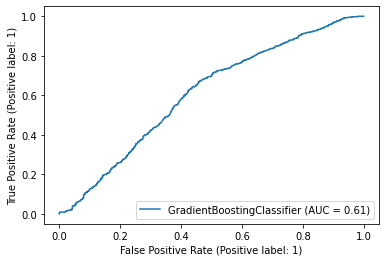

In [27]:
gbdt = GradientBoostingClassifier(
                            max_depth=2,
                            subsample=0.3,
                            max_features=0.2,
                            min_samples_leaf=5,
                            n_estimators = 100
                            )


gbdt.fit(X_train_scaled,y_train)

plot_scores(gbdt,'Gradient Boosting Classifier')
print('Training Accuracy:',accuracy_score(y_train,gbdt.predict(X_train_scaled)))
print('Test Accuracy:', accuracy_score(y_test,gbdt.predict(X_test_scaled)))
plot_confusion_matrix(gbdt,X_val_scaled,y_val)
plot_precision_recall_curve(gbdt,X_val_scaled,y_val)
plot_roc_curve(gbdt, X_val_scaled,y_val)
print('F1Score:', f1_score(y_val,gbdt.predict(X_val_scaled)))

In [157]:
lr = LogisticRegression(C=1,solver='liblinear')

lr = lr.fit(X_train_scaled,y_train)
lr

LogisticRegression(C=1, solver='liblinear')

In [180]:
pred_probs_train = lr.predict_proba(X_train_scaled)[:,1]
pred_probs_test = lr.predict_proba(X_test_scaled)[:,1]
pred_probs_valid = lr.predict_proba(X_val_scaled)[:,1]

<AxesSubplot:ylabel='Density'>

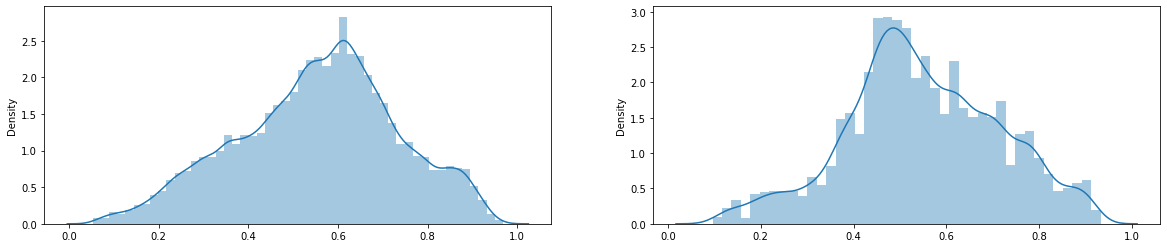

In [181]:
plt.figure(figsize=(20,4))
    
plt.subplot(1,2,1)
sns.distplot(pred_probs_train)

    
plt.subplot(1,2,2)
sns.distplot(pred_probs_test)


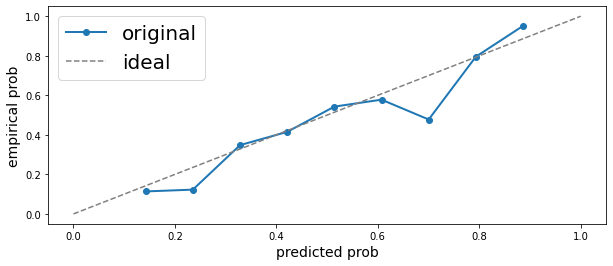

In [182]:
pred_probs = pred_probs_test

pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    empirical_probs.append(np.mean(y_test[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)

plt.figure(figsize=(10,4))
plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)
    
plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
plt.legend(['original', 'ideal'], fontsize=20)

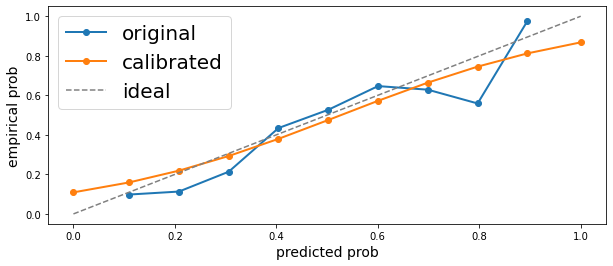

In [183]:
lr_model = LogisticRegression()
lr_model.fit(pred_probs_test.reshape(-1,1), y_test)
pred_probs = pred_probs_valid
pred_probs_space = np.linspace(pred_probs.min(), pred_probs.max(), 10)

empirical_probs = []
pred_probs_midpoints = []

for i in range(len(pred_probs_space)-1):
    empirical_probs.append(np.mean(y_val[(pred_probs > pred_probs_space[i]) & (pred_probs < pred_probs_space[i+1])]))
    pred_probs_midpoints.append((pred_probs_space[i] + pred_probs_space[i+1])/2)
calibrated_probs = lr_model.predict_proba(np.array([0.0]+pred_probs_midpoints+[1.0]).reshape(-1,1))[:,1]
plt.figure(figsize=(10,4))
plt.plot(pred_probs_midpoints, empirical_probs, linewidth=2, marker='o')
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('empirical prob', fontsize=14)
    
plt.plot([0.0]+pred_probs_midpoints+[1.0], calibrated_probs, linewidth=2, marker='o')
    
plt.plot([0,1],[0,1],linestyle='--',color='gray')
    
plt.legend(['original', 'calibrated', 'ideal'], fontsize=20)

In [184]:
uncal = lr.predict_proba(X_test_scaled[3524,:].reshape(1,-1))[:,1][0]

In [185]:
uncal

0.5031596602721283

In [186]:
lr_model.predict_proba(np.array([[uncal]]))[:,1][0]

0.47585920212731114